### **IMPORTATION DES BIBLIOTHÈQUES**

In [1]:
# gestion des données
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import Counter

# Machine Learning et Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Rescaling, Normalization, CenterCrop, RandomFlip
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

# l'évaluation des performances
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ajout du chemin pour accéder aux fichiers locaux
sys.path.append('/kaggle/input/fire-data')

### **PRÉ-TRAITEMENT DES DONNÉES**

In [2]:
def process_dataset(dataset_path):
    """
    Traite un répertoire de données pour extraire les chemins des images et leurs labels associés.
    Retourne un DataFrame avec les chemins d'accès aux fichiers et leurs labels.
    """
    image_dir = Path(dataset_path)
    filepaths = list(image_dir.glob('**/*.JPG')) + list(image_dir.glob('**/*.jpg')) + list(image_dir.glob('**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    dataset_df = pd.concat([filepaths, labels], axis=1)

    return dataset_df

def walk_through_dir(dataset_paths):
    """
    Parcourt plusieurs répertoires de données et combine les chemins d'images et leurs labels dans un seul DataFrame.
    Retourne un DataFrame combiné contenant les informations de tous les répertoires.
    """
    all_datasets = pd.DataFrame(columns=['Filepath', 'Label'])

    for dataset_path in dataset_paths:
        print("-" * 90)
        print(f"Processing directory: {dataset_path}")
        dataset_df = process_dataset(dataset_path)
        all_datasets = pd.concat([all_datasets, dataset_df], ignore_index=True)

    return all_datasets

In [3]:
dataset_paths = [
    "/kaggle/input/fire-data/Data/D1",
    "/kaggle/input/fire-data/Data/D2",
    "/kaggle/input/fire-data/Data/D3",
    "/kaggle/input/fire-data/Data/D4",
    "/kaggle/input/fire-data/Data/D5",
    "/kaggle/input/fire-data/Data/D6",
    "/kaggle/input/fire-data/Data/D7",
    "/kaggle/input/fire-data/Data/D8",
    "/kaggle/input/fire-data/Data/D9",
    "/kaggle/input/fire-data/Data/D10",
    "/kaggle/input/fire-data/Data/D11",
    "/kaggle/input/fire-data/Data/D12",
    "/kaggle/input/fire-data/Data/D13",
    "/kaggle/input/fire-data/Data/D14",
    "/kaggle/input/fire-data/Data/D15",
    "/kaggle/input/fire-data/Data/D16" 
]

final_dataset = walk_through_dir(dataset_paths)

print(final_dataset.info())

------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D1
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D2
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D3
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D4
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D5
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D6
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fir

In [4]:
unique_labels = final_dataset["Label"].unique()

print(unique_labels)

['nonfire4' 'nonfire2' 'nonfire5' 'nonfire3' 'fire' 'nonfire1' 'nonfire'
 'smoke' 'nofire' 'nighttime' 'house' 'street' 'ntime' 'mtime' 'red'
 'test' 'green' 'D16']


In [5]:
label_mapping = {
    'nonfire': 0,
    'nonfire1': 0,
    'nonfire2': 0,
    'nonfire3': 0,
    'nonfire4': 0,
    'nonfire5': 0,
    'nofire': 0,
    'house': 0,
    'street': 0,
    'nighttime': 0,
    'ntime': 0,
    'mtime': 0,
    'red': 0,
    'green': 0,
    'test': 0,
    'D16': 0,   #couleurs
    'fire': 1
}

final_dataset["Label"] = final_dataset["Label"].replace(label_mapping)

final_dataset

Filepath  Label
0      /kaggle/input/fire-data/Data/D1/nonfire4/nonfi...      0
1      /kaggle/input/fire-data/Data/D1/nonfire4/nonfi...      0
2      /kaggle/input/fire-data/Data/D1/nonfire4/nonfi...      0
3      /kaggle/input/fire-data/Data/D1/nonfire2/nonfi...      0
4      /kaggle/input/fire-data/Data/D1/nonfire2/nonfi...      0
...                                                  ...    ...
61236     /kaggle/input/fire-data/Data/D16/nonfire80.png      0
61237    /kaggle/input/fire-data/Data/D16/nonfire121.png      0
61238    /kaggle/input/fire-data/Data/D16/nonfire115.png      0
61239    /kaggle/input/fire-data/Data/D16/nonfire164.png      0
61240    /kaggle/input/fire-data/Data/D16/nonfire129.png      0

[61241 rows x 2 columns]

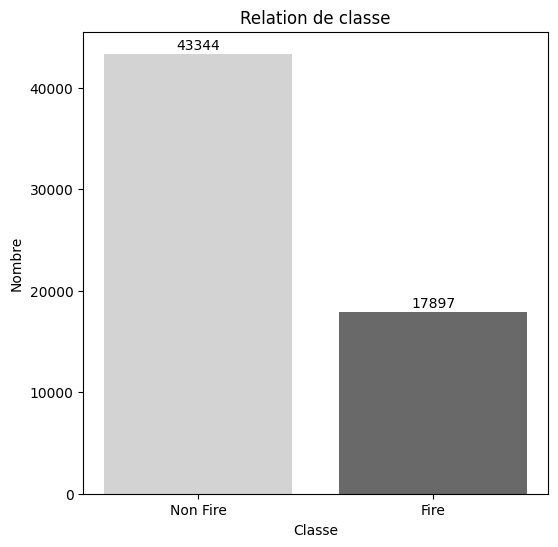

In [6]:
class_counts = final_dataset['Label'].value_counts()

plt.figure(figsize=(6, 6))
plt.bar(class_counts.index, class_counts.values, color=['#d3d3d3', '#696969'])
plt.xlabel('Classe')
plt.ylabel('Nombre')
plt.title('Relation de classe')
plt.xticks(class_counts.index, ['Non Fire', 'Fire'])


for i, value in enumerate(class_counts.values):
    plt.text(i, value + 0.01 * max(class_counts.values), str(value), ha='center')

plt.show()

In [7]:
unique_labels_new = final_dataset["Label"].unique()

# 0 ---> Non fire | 1 ----> Fire
print(unique_labels_new)

[0 1]


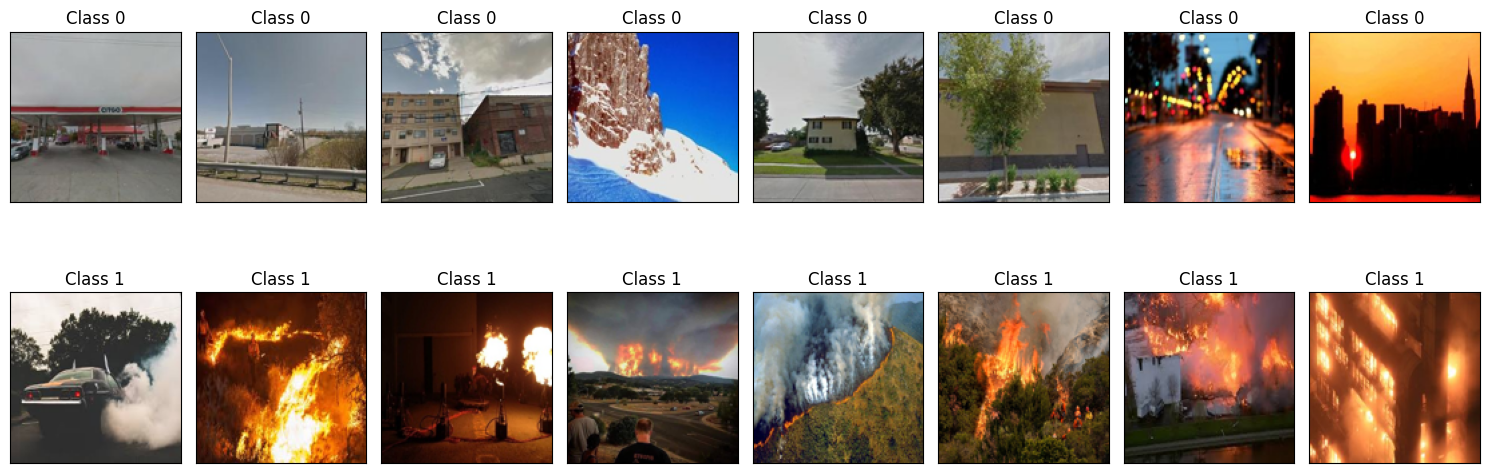

In [8]:
'''
1. On définit le nombre d'images à afficher par classe (8) et la taille uniforme des images (128x128 pixels).
2. Une figure avec 2 rangées (une pour chaque classe) et 8 colonnes est créée. Chaque sous-graphe correspond à une image dans les classes "Non fire" (0) et "Fire" (1).
3. Pour chaque classe, le dataset est filtré afin de ne garder que les images correspondant à la classe actuelle.
4. Ensuite, 8 indices sont sélectionnés aléatoirement parmi les images de la classe.
5. Chaque image est chargée à partir de son chemin d'accès, redimensionnée à la taille spécifiée, puis affichée dans le sous-graphe correspondant.
6. Un titre est ajouté à chaque image pour indiquer la classe.
7. La mise en page est ajustée pour une meilleure présentation des images.

Le résultat est un affichage de 8 images pour chaque classe, permettant de visualiser un échantillon des images de "Non fire" et "Fire".
'''


n_images_per_class = 8

image_size = (128, 128)

fig, axes = plt.subplots(nrows=2, ncols=n_images_per_class, figsize=(15, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

classes = [0, 1]  # 0 = Non fire, 1 = Fire

for row, class_label in enumerate(classes):
    class_images = final_dataset[final_dataset.Label == class_label]
    
    random_index = np.random.choice(class_images.index, n_images_per_class, replace=False)
    
    for col, idx in enumerate(random_index):
        image = Image.open(final_dataset.Filepath[idx]).resize(image_size)
        ax = axes[row, col]
        ax.imshow(image)
        ax.set_title(f"Class {class_label}")

plt.tight_layout()
plt.show()

### **GÉNÉRATEURS IMAGES**

In [9]:
train_df, test_df = train_test_split(final_dataset, test_size=0.15, shuffle=True, random_state=42)

In [10]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    rescale=1./255
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 41644 validated image filenames.
Found 10410 validated image filenames.
Found 9187 validated image filenames.


In [12]:
images, labels = train_images[0]
print("Shape des images :", images.shape)
print("Shape des labels :", labels.shape)

Shape des images : (32, 224, 224, 3)
Shape des labels : (32,)


In [13]:
''' 
Affiche la répartition des classes dans un générateur d'images avec un graphique à barres.
'''
def visualize_class_distribution(generator, title):

    if hasattr(generator, 'labels'): 
        labels = generator.labels
    else:
        labels = []
        for i in range(len(generator)):
            _, batch_labels = generator[i]
            labels.extend(batch_labels)
    
    class_counts = Counter(labels)
    class_names = ['Non-Fire', 'Fire'] 
    counts = [class_counts.get(0, 0), class_counts.get(1, 0)] 
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    colors = ['#d3d3d3', '#696969']
    ax = sns.barplot(x=class_names, y=counts, palette=colors)
    
    for i, count in enumerate(counts):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

    plt.title(title, fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


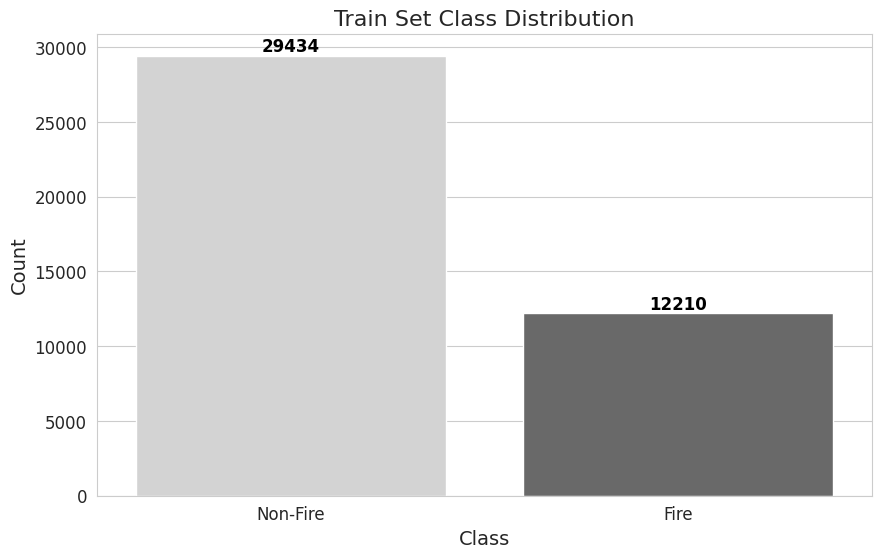

In [14]:
visualize_class_distribution(train_images, 'Train Set Class Distribution')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


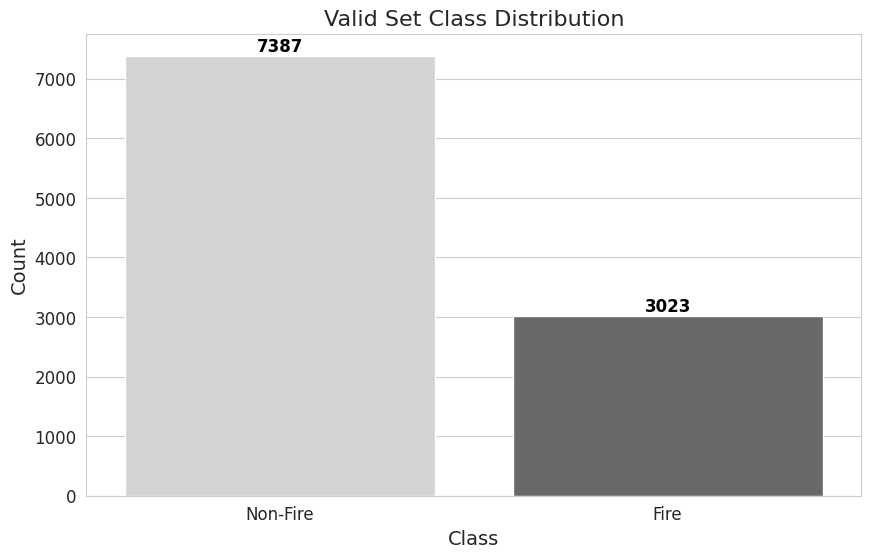

In [15]:
visualize_class_distribution(val_images, 'Valid Set Class Distribution')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


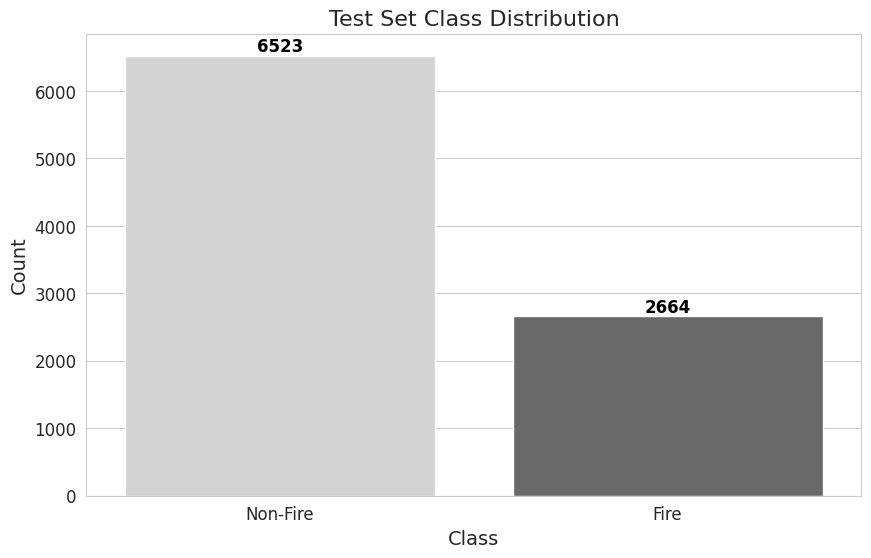

In [16]:
visualize_class_distribution(test_images, 'Test Set Class Distribution')

### **CONCEPTION DES MODÈLES**

In [17]:
def accuracy(y_true, y_pred):
    """
    Calcule la métrique Accuracy (Précision).

    Paramètres:
    - y_true : Véritables étiquettes de classe (numpy array ou liste)
    - y_pred : Étiquettes prédites (numpy array ou liste)

    Retourne:
    - Valeur de la précision (Accuracy)
    """
    correct_predictions = tf.reduce_sum(tf.cast(tf.equal(y_true, tf.round(y_pred)), tf.float32))
    total_samples = tf.cast(tf.size(y_true), tf.float32)
    accuracy_value = correct_predictions / total_samples * 100
    return accuracy_value

def precision(y_true, y_pred, positive_class=1):
    """
    Calcule la métrique Precision.

    Paramètres:
    - y_true : Véritables étiquettes de classe (numpy array ou liste)
    - y_pred : Étiquettes prédites (numpy array ou liste)
    - positive_class : Classe pour laquelle la Precision est calculée

    Retourne:
    - Valeur de la précision (Precision)
    """
    true_positive = np.sum((np.array(y_true) == positive_class) & (np.array(y_pred) == positive_class))
    predicted_positive = np.sum(np.array(y_pred) == positive_class)
    
    precision_value = true_positive / predicted_positive if predicted_positive != 0 else 0
    return precision_value

def recall(y_true, y_pred, positive_class=1):
    """
    Calcule la métrique Recall (Rappel).

    Paramètres:
    - y_true : Véritables étiquettes de classe (numpy array ou liste)
    - y_pred : Étiquettes prédites (numpy array ou liste)
    - positive_class : Classe pour laquelle le Recall est calculé

    Retourne:
    - Valeur du rappel (Recall)
    """
    true_positive = np.sum((np.array(y_true) == positive_class) & (np.array(y_pred) == positive_class))
    actual_positive = np.sum(np.array(y_true) == positive_class)

    recall_value = true_positive / actual_positive if actual_positive != 0 else 0
    return recall_value

def f1_score(y_true, y_pred, positive_class=1):
    """
    Calcule la métrique F1-score.

    Paramètres:
    - y_true : Véritables étiquettes de classe (numpy array ou liste)
    - y_pred : Étiquettes prédites (numpy array ou liste)
    - positive_class : Classe pour laquelle le F1-score est calculé

    Retourne:
    - Valeur du F1-score
    """
    precision_value = precision(y_true, y_pred, positive_class)
    recall_value = recall(y_true, y_pred, positive_class)

    f1_score_value = 2 * (precision_value * recall_value) / (precision_value + recall_value) if (precision_value + recall_value) != 0 else 0
    return f1_score_value

In [18]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal")
])

In [19]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1, 
    restore_best_weights=True
)

In [20]:
checkpoint_path_Alex = '/kaggle/working/AlexNet.keras'
checkpoint_path_Vgg = '/kaggle/working/VggNet.keras'
checkpoint_path_Res = '/kaggle/working/ResNet.keras'
checkpoint_path_Cnn = '/kaggle/working/Cnn.keras'
checkpoint_path_CnnP = '/kaggle/working/CnnParallel.keras'

In [21]:
def train_model(model, train_images, val_images, epochs=20):
    # Initialiser les listes pour enregistrer les données de l'historique
    all_training_loss = []
    all_val_loss = []
    all_training_acc = []
    all_val_acc = []
    
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        try:
            # Entraînement pour une époque
            history = model.fit(
                train_images,
                steps_per_epoch=len(train_images),
                validation_data=val_images,
                validation_steps=len(val_images),
                epochs=1,
                callbacks=[
                    early_stopping,
                    checkpoint_callback
                ]
            )
            
            # Ajouter les valeurs des métriques pour cette époque
            all_training_loss.append(history.history['loss'][0])
            all_val_loss.append(history.history['val_loss'][0])
            all_training_acc.append(history.history['accuracy'][0])
            all_val_acc.append(history.history['val_accuracy'][0])

        except StopIteration:
            continue

        except Exception as e:
            print(f"Une erreur s'est produite pendant l'époque {epoch}: {e}")
            break

        # Vérifier si l'arrêt précoce a été déclenché
        if early_stopping.stopped_epoch > 0:
            print("L'entraînement a été interrompu en raison de l'arrêt précoce.")
            break

    print("L'entraînement s'est terminé.")
    
    # Retourner les historiques accumulés
    return {
        "training_loss": all_training_loss,
        "val_loss": all_val_loss,
        "training_accuracy": all_training_acc,
        "val_accuracy": all_val_acc
    }

### **1- AlexNet**

In [22]:
def AlexNet():
    inp = layers.Input((224, 224, 3))
    
    # Bloc 1
    x = layers.Conv2D(96, kernel_size=11, strides=4, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    
    # Bloc 2
    x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    
    # Bloc 3
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    
    # Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer for binary classification
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inp, outputs=x)
    return model

model_Alex = AlexNet()
model_Alex.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,752,513 (178.35 MB)

 Trainable params: 46,751,809 (178.34 MB)

 Non-trainable params: 704 (2.75 KB)

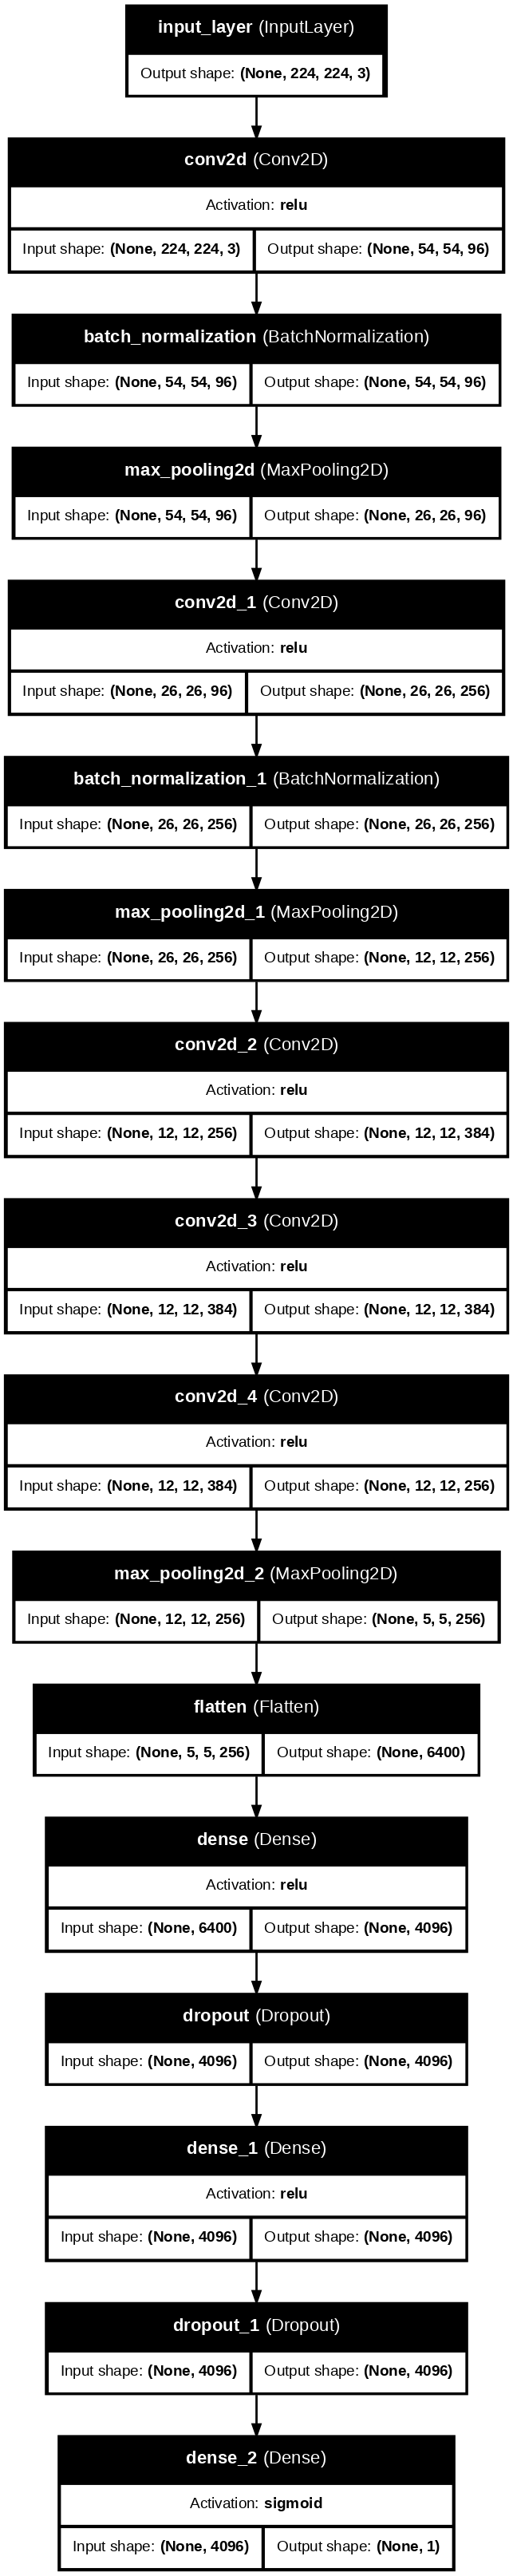

In [23]:
tf.keras.utils.plot_model(
    model_Alex,
    to_file='alex_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [24]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_Alex,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

In [25]:
if __name__ == "__main__":


    model_Alex.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Entraîner le modèle
    history_data = train_model(model_Alex, train_images, val_images, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1302/1302 ━━━━━━━━━━━━━━━━━━━━ 941s 712ms/step - accuracy: 0.8885 - loss: 0.3036 - val_accuracy: 0.9255 - val_loss: 0.2105
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 769s 588ms/step - accuracy: 0.9296 - loss: 0.1971 - val_accuracy: 0.9176 - val_loss: 0.2402
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 774s 592ms/step - accuracy: 0.9399 - loss: 0.1662 - val_accuracy: 0.9388 - val_loss: 0.1716
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 773s 591ms/step - accuracy: 0.9455 - loss: 0.1511 - val_accuracy: 0.9489 - val_loss: 0.1500
Restoring model weights from the end of the best epoch: 1.
Epoch 5/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 764s 584ms/step - accuracy: 0.9492 - loss: 0.1443 - val_accuracy: 0.8889 - val_loss: 0.2576
Restoring model weights from the end of the best epoch: 1.
Epoch 6/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 770s

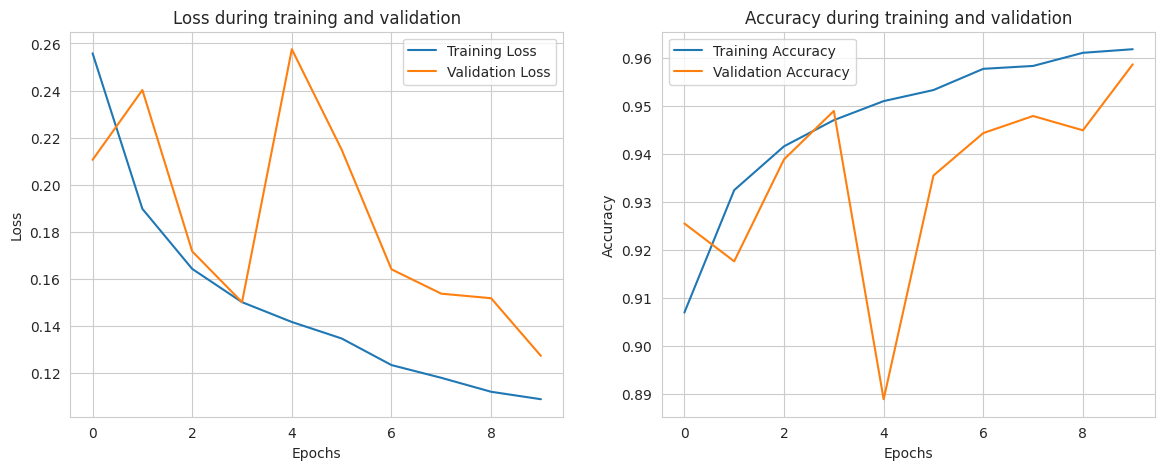

In [26]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['training_loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['training_accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
test_predictions = model_Alex.predict(test_images)
test_labels = test_df['Label'].values

binary_predictions = np.round(test_predictions).flatten()

print("Classification Report:")
print(classification_report(test_labels, binary_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, binary_predictions))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")

288/288 ━━━━━━━━━━━━━━━━━━━━ 114s 393ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6523
           1       0.96      0.92      0.94      2664

    accuracy                           0.96      9187
   macro avg       0.96      0.95      0.96      9187
weighted avg       0.96      0.96      0.96      9187


Confusion Matrix:
[[6410  113]
 [ 209 2455]]

Metrics:
Accuracy: 96.50%
Precision: 0.96
Recall: 0.92
F1-Score: 0.94


### **2- VGGNET**

In [29]:
def VGGNet():
    inp = layers.Input((224, 224, 3))
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(inp)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    model_VGG = models.Model(inputs=inp, outputs=x)

    return model_VGG

model_VGG = VGGNet()
model_VGG.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,270,529 (512.20 MB)

 Trainable params: 134,267,585 (512.19 MB)

 Non-trainable params: 2,944 (11.50 KB)

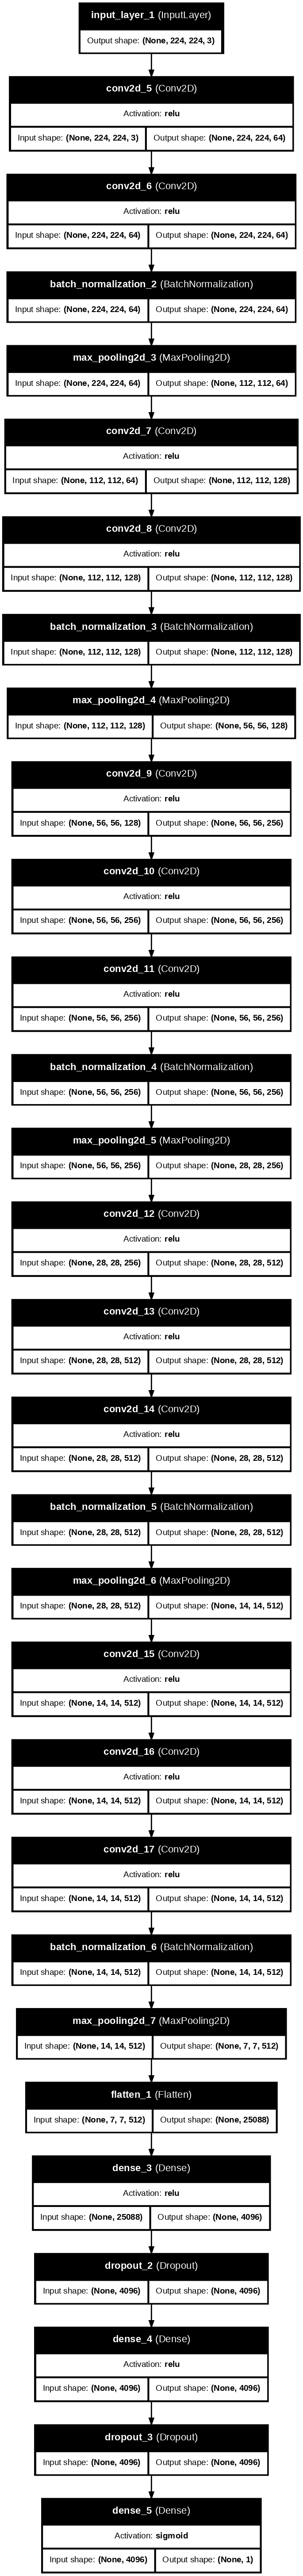

In [30]:
tf.keras.utils.plot_model(
    model_VGG,
    to_file='VGG_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [31]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_Vgg,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

In [32]:
if __name__ == "__main__":


    model_VGG.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Entraîner le modèle
    history_data = train_model(model_VGG, train_images, val_images, epochs=10)

Epoch 1/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 974s 706ms/step - accuracy: 0.8418 - loss: 0.7062 - val_accuracy: 0.8424 - val_loss: 0.3841
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 876s 670ms/step - accuracy: 0.9237 - loss: 0.2362 - val_accuracy: 0.9336 - val_loss: 0.1772
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 871s 666ms/step - accuracy: 0.9364 - loss: 0.1812 - val_accuracy: 0.9169 - val_loss: 0.2426
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 871s 667ms/step - accuracy: 0.9443 - loss: 0.1609 - val_accuracy: 0.8458 - val_loss: 0.3484
Restoring model weights from the end of the best epoch: 1.
Epoch 5/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 906s 693ms/step - accuracy: 0.9497 - loss: 0.1522 - val_accuracy: 0.9517 - val_loss: 0.1342
Restoring model weights from the end of the best epoch: 1.
Epoch 6/10
1302/1302 ━━━━━━━━━━━━━━

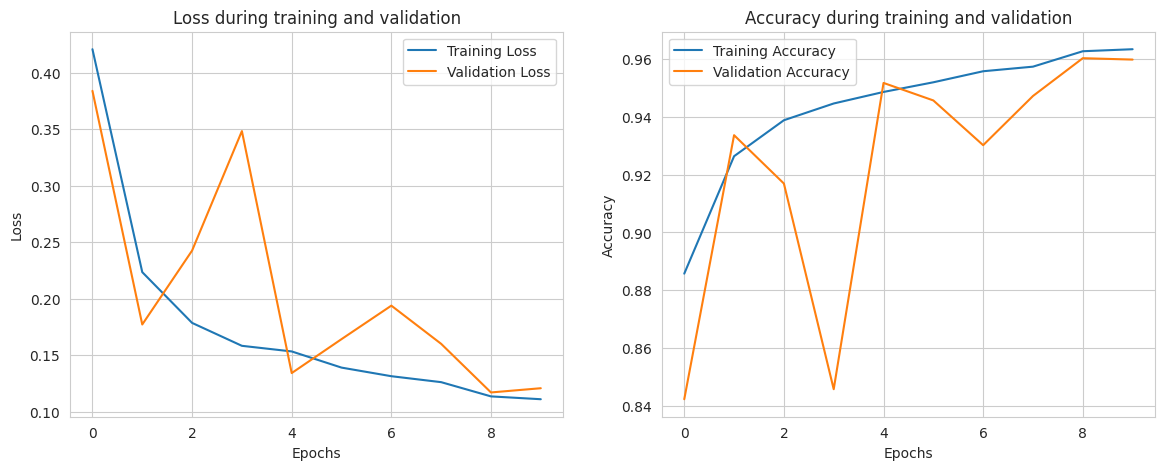

In [33]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['training_loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['training_accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
test_predictions = model_VGG.predict(test_images)
test_labels = test_df['Label'].values

binary_predictions = np.round(test_predictions).flatten()

print("Classification Report:")
print(classification_report(test_labels, binary_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, binary_predictions))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")

288/288 ━━━━━━━━━━━━━━━━━━━━ 115s 391ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6523
           1       0.97      0.89      0.93      2664

    accuracy                           0.96      9187
   macro avg       0.96      0.94      0.95      9187
weighted avg       0.96      0.96      0.96      9187


Confusion Matrix:
[[6446   77]
 [ 280 2384]]

Metrics:
Accuracy: 96.11%
Precision: 0.97
Recall: 0.89
F1-Score: 0.93


### **3-ResNet**

In [36]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    """Un bloc résiduel.
    
    Args:
        x (Tensor): Entrée du bloc résiduel.
        filters (int): Nombre de filtres pour les convolutions.
        kernel_size (int): Taille des noyaux de convolution. Par défaut, 3.
        stride (int): Décalage pour la première couche convolutionnelle. Par défaut, 1.
        conv_shortcut (bool): Si True, applique une couche convolutionnelle au chemin de raccourci.

    Returns:
        Tensor: La sortie après application du bloc résiduel.
    """
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x

    # Première convolution
    x = layers.Conv2D(filters, kernel_size, stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Deuxième convolution
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Ajouter la connexion résiduelle
    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)

    return x

# Définir le modèle ResNet34
def ResNet34():
    inp = layers.Input((224, 224, 3))
    x = layers.Conv2D(64, 7, 2, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Blocs résiduels
    x = residual_block(x, 64, conv_shortcut=False)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x) 

    model_Res = models.Model(inputs=inp, outputs=x)
    return model_Res

model_Res = ResNet34()
model_Res.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 112, 112, 64)   │            256 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 56, 56, 64)     │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 56, 56, 64)     │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 64)     │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 56, 56, 64)     │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ max_pooling2d_8[0][0], │
│                           │                        │                │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 56, 56, 64)     │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 56, 56, 64)     │          4,160 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_2[0][0]          │
├──────────────────────

 Total params: 41,120,257 (156.86 MB)

 Trainable params: 41,097,601 (156.77 MB)

 Non-trainable params: 22,656 (88.50 KB)

In [37]:
tf.keras.utils.plot_model(
    model_Res,
    to_file='Res_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [38]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_Res,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

In [41]:
if __name__ == "__main__":


    model_Res.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Entraîner le modèle
    history_data = train_model(model_Res, train_images, val_images, epochs=10)

Epoch 1/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 994s 728ms/step - accuracy: 0.9530 - loss: 0.1392 - val_accuracy: 0.9491 - val_loss: 0.1811
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 931s 712ms/step - accuracy: 0.9521 - loss: 0.1471 - val_accuracy: 0.9517 - val_loss: 0.1700
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 918s 702ms/step - accuracy: 0.9495 - loss: 0.1501 - val_accuracy: 0.9590 - val_loss: 0.1220
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 926s 708ms/step - accuracy: 0.9567 - loss: 0.1249 - val_accuracy: 0.9438 - val_loss: 0.1548
Restoring model weights from the end of the best epoch: 1.
Epoch 5/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 951s 727ms/step - accuracy: 0.9535 - loss: 0.1379 - val_accuracy: 0.9144 - val_loss: 0.2277
Restoring model weights from the end of the best epoch: 1.
Epoch 6/10
1302/1302 ━━━━━━━━━━━━━━

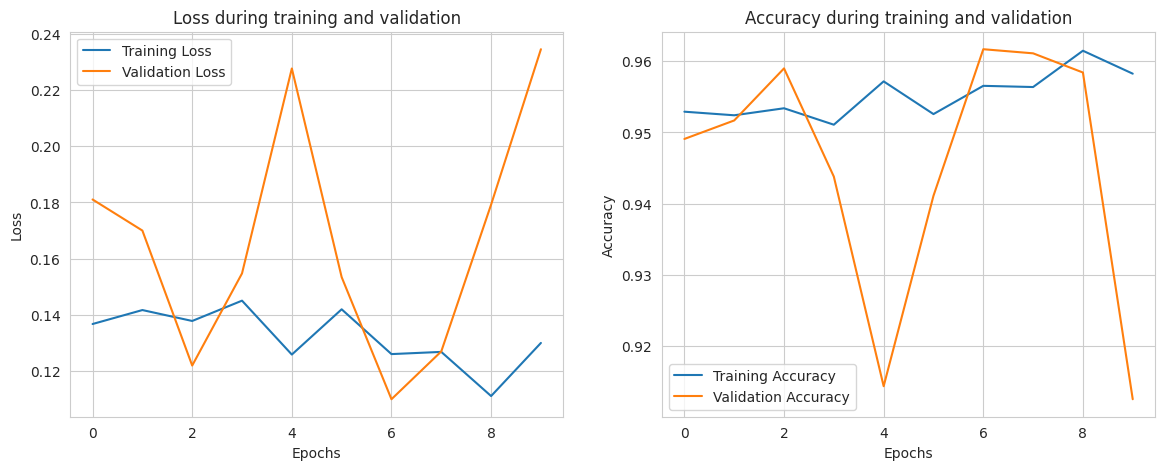

In [42]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['training_loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['training_accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [43]:
test_predictions = model_Res.predict(test_images)
test_labels = test_df['Label'].values

binary_predictions = np.round(test_predictions).flatten()

print("Classification Report:")
print(classification_report(test_labels, binary_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, binary_predictions))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")

288/288 ━━━━━━━━━━━━━━━━━━━━ 114s 381ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      6523
           1       0.82      0.97      0.89      2664

    accuracy                           0.93      9187
   macro avg       0.91      0.94      0.92      9187
weighted avg       0.94      0.93      0.93      9187


Confusion Matrix:
[[5965  558]
 [  69 2595]]

Metrics:
Accuracy: 93.18%
Precision: 0.82
Recall: 0.97
F1-Score: 0.89
